<a href="https://colab.research.google.com/github/Andrey-Epifanov-k721/conv_networks/blob/master/GAN_Flickr_Faces_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive_face.zip

In [3]:
DATA_DIR = './faces_dataset_small/'

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [4]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torchvision import datasets, transforms

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [5]:
import os
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir, image_size):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        self.transform = Compose([
            Resize(image_size),
            ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image_path = os.path.join(self.root_dir, image_file)
        image = Image.open(image_path)
        image = self.transform(image)
        return image

def get_dataloader(image_size, batch_size):
    dataset = CustomDataset(DATA_DIR, image_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader



In [84]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [86]:
train_data = get_dataloader(image_size, batch_size)

In [87]:
# кол-во картинок в датасете / batch_size
len(train_data)

25

In [88]:
# Получение количества пакетов в DataLoader
num_batches = len(train_data)

# Получение общего количества образцов в DataLoader
num_samples = len(train_data.dataset)

print("Количество пакетов:", num_batches)
print("Количество образцов:", num_samples)

Количество пакетов: 25
Количество образцов: 3143


In [89]:
dataloader = get_dataloader(image_size, batch_size)

In [90]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(dataloader):
    # Получаем пакет изображений из dataloader
    images = next(iter(dataloader))
    
    # Создаем сетку изображений
    grid = vutils.make_grid(images[:25], nrow=5, normalize=True)
    
    # Выводим сетку на экран
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


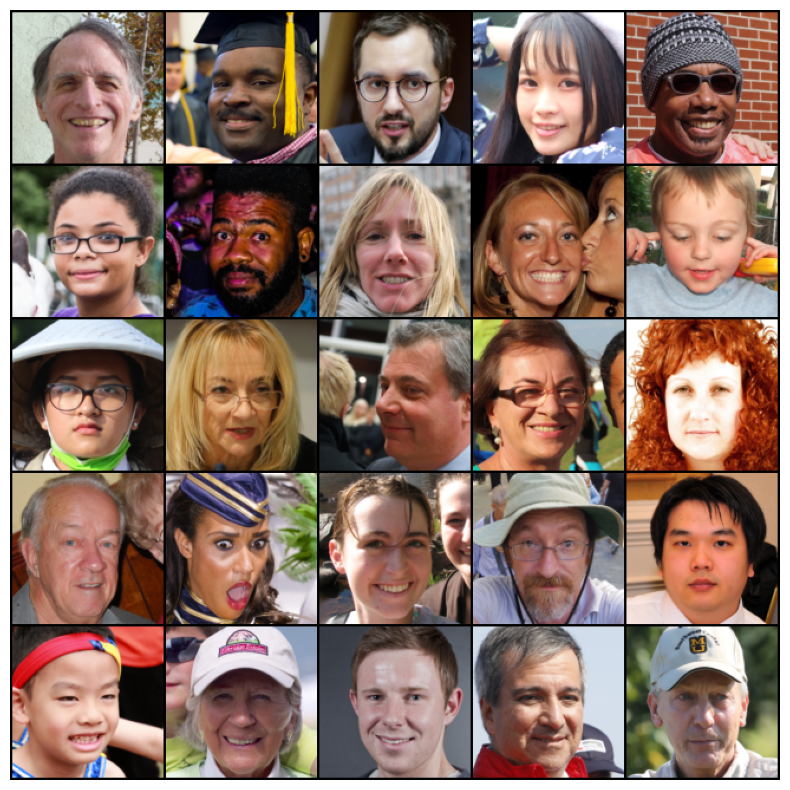

In [91]:
show_images(dataloader)


In [92]:
#TODO: build dataloader and transfer it to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [93]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [94]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=11, stride=1, padding=0, bias=False),   # 118x118
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 118 x 118

    nn.Conv2d(64, 128, kernel_size=21, stride=1, padding=0, bias=False), # 98x98
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 98 x 98

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=0, bias=False),  # 48x48
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 48 x 48

    nn.Conv2d(256, 512, kernel_size=6, stride=2, padding=0, bias=False),  # 22x22
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 22 x 22

    nn.Conv2d(512, 1, kernel_size=22, stride=1, padding=0, bias=False),   # 1x1
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [95]:
discriminator = to_device(discriminator, device)

In [96]:
latent_size = 128 

In [97]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=12, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [98]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    # out: 32 x 64 x 64

        nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)


In [99]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [100]:
lr = 0.0001

model = {"discriminator": discriminator, "generator": generator}

criterion = {"discriminator": nn.BCELoss(), "generator": nn.BCELoss()}

In [101]:
# Метод train() в PyTorch используется для установки режима обучения модели. 
# Когда модель находится в режиме обучения (model.train()), некоторые слои, такие 
# как Dropout или Batch Normalization, могут работать по-разному, чем во время 
# оценки или инференса.

# Вызов model["discriminator"].train() и model["generator"].train() в функции
# fit() позволяет установить оба этих модуля в режим обучения перед выполнением
# обучения и обновлением параметров. Это важно, чтобы модели корректно
# выполняли обучение, используя оптимизатор и потери, указанные в функции fit().

In [102]:
import torch.optim as optim

def fit(model, criterion, epochs, lr):
    # переводим нейронные сети в режим обучения
    model["discriminator"].train()
    model["generator"].train()

    # присваиваем модели дискриминатора и генератора к переменным для удобства
    discriminator = model["discriminator"]
    generator = model["generator"]
    
    # нужны ли?
    # Оптимизаторы для обновления параметров дискриминатора и генератора
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))}

In [129]:
epochs = 30

In [104]:
optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))}

In [105]:
# работает, отлажено
# for epoch in range(epochs):
#     loss_d_per_epoch = []
#     loss_g_per_epoch = []
#     real_score_per_epoch = []
#     fake_score_per_epoch = []

#     for real_images in tqdm(dataloader):
#     # Обучение дискриминатора
#         # Очистим градиенты дискриминатора
#         optimizer['discriminator'].zero_grad()

#     # пропустим реальные изображения через дискриминатор
#         real_preds = model["discriminator"](real_images.to(device))
#         print(real_preds.size())

#         # создадим метки класса 1 для реальных изображений
#         # real_targets представляет собой тензор меток классов, состоящий из 
#         # единиц, с размерностью (размер батча, 1)
#         real_targets = torch.ones(real_images.size(0), 1, device=device)
#         print(real_targets.size())

#         # вычислим лосс
#         real_loss = criterion["discriminator"](real_preds, real_targets)

#         # вычислим средний скор дискриминатора на реальных изображениях
#         cur_real_score = torch.mean(real_preds).item()



#     # пропустим фейковые изображения через дискриминатор
#         # сгенерируем фейковые изображения
#         latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # torch.Size([32, 128, 1, 1])
#         fake_images = model["generator"](latent)
#         print('размерность fake_images: ', fake_images.size())

#         # создадим метки класса 0 для фейковых изображений
#         fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

#         # Пропустим фейковые изображения через дискриминатор
#         fake_preds = model["discriminator"](fake_images)

#         # вычислим лосс дискриминатора
#         fake_loss = criterion["discriminator"](fake_preds, fake_targets)

#         # вычислим средний скор дискриминатора на фейковых изображениях
#         cur_fake_score = torch.mean(fake_preds).item()

#         # код обновления весов дискриминатора
#         loss_d = real_loss + fake_loss
#         loss_d.backward()
#         optimizer["discriminator"].step()
#         loss_d_per_epoch.append(loss_d.item())


#         # Обучение генератора
#         model["generator"].zero_grad()

#         # Генерация фейковых изображений
#         latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
#         fake_images = model["generator"](latent)

#         # пропустим фейковые изображения через дискриминатор
#         preds = model["discriminator"](fake_images)

#         # Создадим метки класса 1 для того, чтобы обмануть дискриминатор
#         targets = torch.ones(batch_size, 1, device=device)

#         # вычислим лосс генератора
#         loss_g = criterion["generator"](preds, targets)

#         # код обновления параметров генератора
#         loss_g.backward()
#         optimizer["generator"].step()
#         loss_g_per_epoch.append(loss_g.item())

        
#         # Вывод информации о прогрессе обучения
#         discriminator_loss = torch.mean(torch.FloatTensor(loss_d_per_epoch))
#         generator_loss = torch.mean(torch.FloatTensor(loss_g_per_epoch))
#         print(f"Epoch [{epoch+1}/{epochs}] - Discriminator Loss: {discriminator_loss.item():.4f} - Generator Loss: {generator_loss.item():.4f}")


In [106]:
# # обучение дополненное метриками
# losses_d = []  # Список для хранения значений loss дискриминатора
# losses_g = []  # Список для хранения значений loss генератора
# real_scores = []  # Список для хранения значений скора на реальных изображениях
# fake_scores = []  # Список для хранения значений скора на фейковых изображениях

# for epoch in range(epochs):
#     loss_d_per_epoch = []
#     loss_g_per_epoch = []
#     real_score_per_epoch = []
#     fake_score_per_epoch = []

#     for real_images in tqdm(dataloader):
#         # Обучение дискриминатора
#         optimizer['discriminator'].zero_grad()
        
#         real_preds = model["discriminator"](real_images.to(device))
#         real_targets = torch.ones(real_images.size(0), 1, device=device)
#         real_loss = criterion["discriminator"](real_preds, real_targets)
#         cur_real_score = torch.mean(real_preds).item()

#         fake_images = model["generator"](torch.randn(batch_size, latent_size, 1, 1, device=device))
#         fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
#         fake_preds = model["discriminator"](fake_images)
#         fake_loss = criterion["discriminator"](fake_preds, fake_targets)
#         cur_fake_score = torch.mean(fake_preds).item()

#         loss_d = real_loss + fake_loss
#         loss_d.backward()
#         optimizer["discriminator"].step()
#         loss_d_per_epoch.append(loss_d.item())

#         # Обучение генератора
#         model["generator"].zero_grad()

#         latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
#         fake_images = model["generator"](latent)

#         preds = model["discriminator"](fake_images)

#         targets = torch.ones(batch_size, 1, device=device)

#         loss_g = criterion["generator"](preds, targets)
#         loss_g.backward()
#         optimizer["generator"].step()
#         loss_g_per_epoch.append(loss_g.item())

#         # Сохранение значений loss и скоров в текущей эпохе
#         loss_d_per_epoch.append(loss_d.item())
#         loss_g_per_epoch.append(loss_g.item())
#         real_score_per_epoch.append(cur_real_score)
#         fake_score_per_epoch.append(cur_fake_score)

#     # Сохранение средних значений loss и скоров по эпохе
#     losses_d.append(torch.mean(torch.FloatTensor(loss_d_per_epoch)))
#     losses_g.append(torch.mean(torch.FloatTensor(loss_g_per_epoch)))
#     real_scores.append(torch.mean(torch.FloatTensor(real_score_per_epoch)))
#     fake_scores.append(torch.mean(torch.FloatTensor(fake_score_per_epoch)))

#     # Вывод информации о прогрессе обучения
#     print(f"Epoch [{epoch+1}/{epochs}] - Discriminator Loss: {losses_d[-1]:.4f} - Generator Loss: {losses_g[-1]:.4f}")

In [130]:
# обучение дополненное метриками
losses_d = []  # Список для хранения значений loss дискриминатора
losses_g = []  # Список для хранения значений loss генератора
real_scores = []  # Список для хранения значений скора на реальных изображениях
fake_scores = []  # Список для хранения значений скора на фейковых изображениях

for epoch in range(epochs):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for real_images in tqdm(dataloader):
    # Обучение дискриминатора
        # Очистим градиенты дискриминатора
        optimizer['discriminator'].zero_grad()

    # пропустим реальные изображения через дискриминатор
        real_preds = model["discriminator"](real_images.to(device))
        # print(real_preds.size())

        # создадим метки класса 1 для реальных изображений
        # real_targets представляет собой тензор меток классов, состоящий из 
        # единиц, с размерностью (размер батча, 1)
        real_targets = torch.ones(real_images.size(0), 1, device=device)
        # print(real_targets.size())

        # вычислим лосс
        real_loss = criterion["discriminator"](real_preds, real_targets)

        # вычислим средний скор дискриминатора на реальных изображениях
        cur_real_score = torch.mean(real_preds).item()



    # пропустим фейковые изображения через дискриминатор
        # сгенерируем фейковые изображения
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # torch.Size([32, 128, 1, 1])
        fake_images = model["generator"](latent)
        # print('размерность fake_images: ', fake_images.size())

        # создадим метки класса 0 для фейковых изображений
        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

        # Пропустим фейковые изображения через дискриминатор
        fake_preds = model["discriminator"](fake_images)

        # вычислим лосс дискриминатора
        fake_loss = criterion["discriminator"](fake_preds, fake_targets)

        # вычислим средний скор дискриминатора на фейковых изображениях
        cur_fake_score = torch.mean(fake_preds).item()

        # код обновления весов дискриминатора
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer["discriminator"].step()
        loss_d_per_epoch.append(loss_d.item())


        # Обучение генератора
        model["generator"].zero_grad()

        # Генерация фейковых изображений
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)

        # пропустим фейковые изображения через дискриминатор
        preds = model["discriminator"](fake_images)

        # Создадим метки класса 1 для того, чтобы обмануть дискриминатор
        targets = torch.ones(batch_size, 1, device=device)

        # вычислим лосс генератора
        loss_g = criterion["generator"](preds, targets)

        # код обновления параметров генератора
        loss_g.backward()
        optimizer["generator"].step()
        loss_g_per_epoch.append(loss_g.item())

        
        # Сохранение значений loss и скоров в текущей эпохе
        loss_d_per_epoch.append(loss_d.item())
        loss_g_per_epoch.append(loss_g.item())
        real_score_per_epoch.append(cur_real_score)
        fake_score_per_epoch.append(cur_fake_score)

    # Сохранение средних значений loss и скоров по эпохе
    losses_d.append(torch.mean(torch.FloatTensor(loss_d_per_epoch)))
    losses_g.append(torch.mean(torch.FloatTensor(loss_g_per_epoch)))
    real_scores.append(torch.mean(torch.FloatTensor(real_score_per_epoch)))
    fake_scores.append(torch.mean(torch.FloatTensor(fake_score_per_epoch)))

        
    # # Вывод информации о прогрессе обучения
    # discriminator_loss = torch.mean(torch.FloatTensor(loss_d_per_epoch))
    # generator_loss = torch.mean(torch.FloatTensor(loss_g_per_epoch))
    # print(f"Epoch [{epoch+1}/{epochs}] - Discriminator Loss: {discriminator_loss.item():.4f} - Generator Loss: {generator_loss.item():.4f}")

    # Вывод информации о прогрессе обучения
    print(f"Epoch [{epoch+1}/{epochs}] - Discriminator Loss: {losses_d[-1]:.4f} - Generator Loss: {losses_g[-1]:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/30] - Discriminator Loss: 0.0003 - Generator Loss: 43.1993


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/30] - Discriminator Loss: 0.0002 - Generator Loss: 43.0404


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/30] - Discriminator Loss: 0.0002 - Generator Loss: 42.9425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.8193


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.7450


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.6507


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.5568


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.4997


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.4284


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.3748


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/30] - Discriminator Loss: 0.0001 - Generator Loss: 42.3004


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/30] - Discriminator Loss: 0.0000 - Generator Loss: 42.2553


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/30] - Discriminator Loss: 0.0000 - Generator Loss: 42.1877


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/30] - Discriminator Loss: 0.0000 - Generator Loss: 42.1304


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/30] - Discriminator Loss: 0.0000 - Generator Loss: 42.0804


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/30] - Discriminator Loss: 0.0000 - Generator Loss: 42.0494


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.9682


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.8816


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.8311


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.7543


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.6878


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.6402


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.5774


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.5196


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.4451


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.3919


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.3145


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.2459


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.1530


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/30] - Discriminator Loss: 0.0000 - Generator Loss: 41.0397


In [131]:
from google.colab import drive
import torch

# Укажите путь к файлу на Google Диске, куда хотите сохранить модель
path = '/content/drive/MyDrive/model_GAN_Faces_generator.h5'

# Сохранение модели
torch.save(model["generator"].state_dict(), path)

print("Модель generator успешно сохранена на Google Диск по пути:", path)

Модель generator успешно сохранена на Google Диск по пути: /content/drive/MyDrive/model_GAN_Faces_generator.h5


In [132]:
# Укажите путь к файлу на Google Диске, куда хотите сохранить модель
path = '/content/drive/MyDrive/model_GAN_Faces_discriminator.h5'

# Сохранение модели
torch.save(model["discriminator"].state_dict(), path)

print("Модель discriminator успешно сохранена на Google Диск по пути:", path)

Модель discriminator успешно сохранена на Google Диск по пути: /content/drive/MyDrive/model_GAN_Faces_discriminator.h5


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

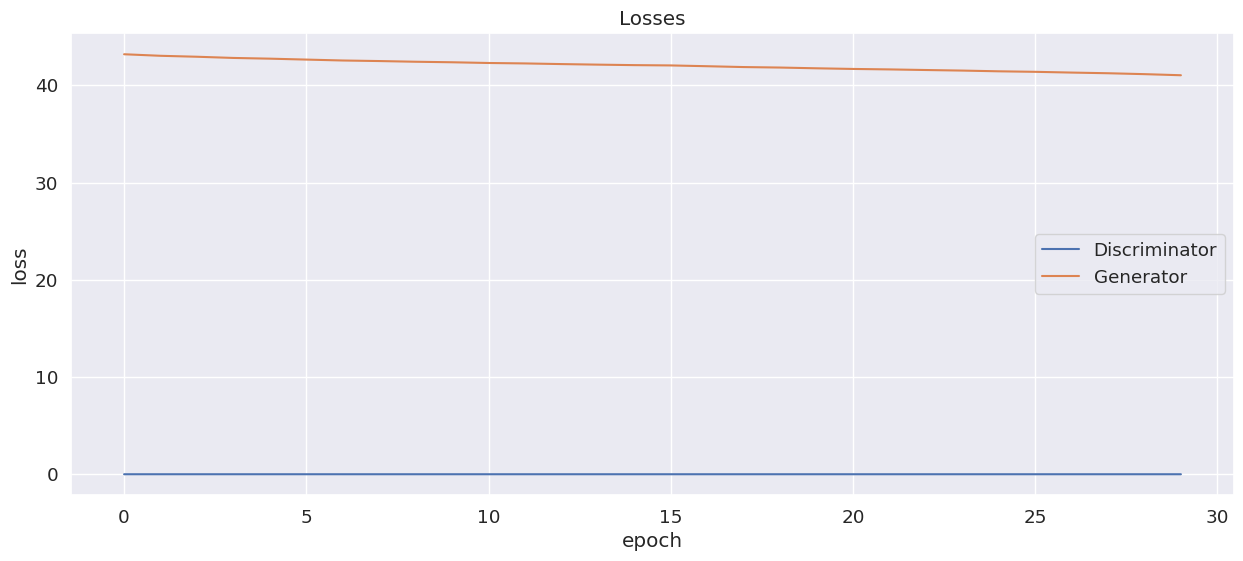

In [133]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

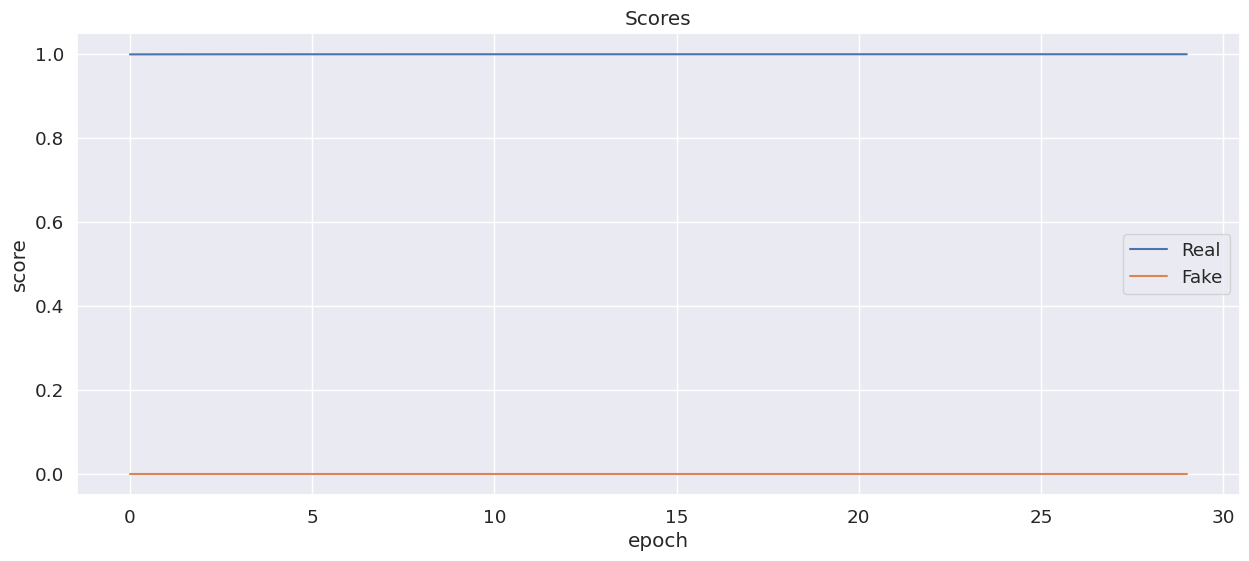

In [134]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [135]:
n_images = 1

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
generated_img = model["generator"](fixed_latent)

In [136]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(generated):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])

    # Нормализация значений пикселей к диапазону [0, 1]
    normalized_img = vutils.make_grid(generated, normalize=True)

    ax.imshow(normalized_img.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

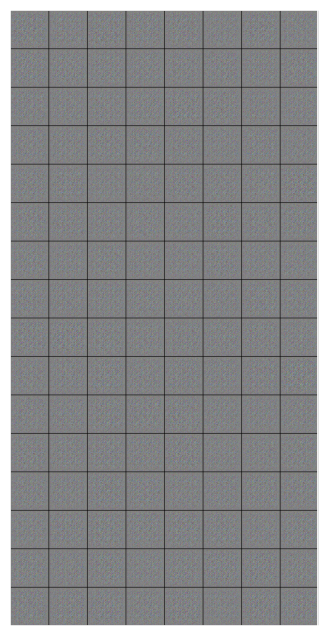

In [137]:
show_images(fake_images)

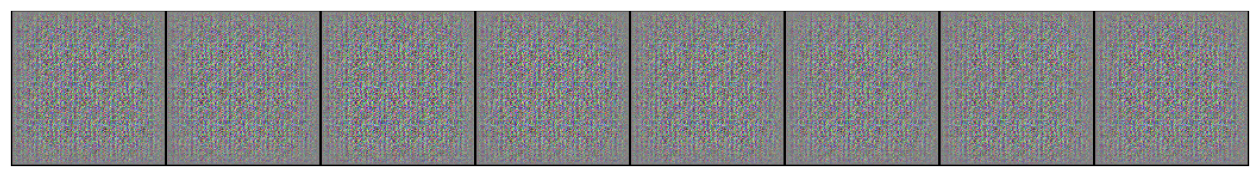

In [138]:
n_images = 8

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
generated_img = model["generator"](fixed_latent) 
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(generated):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([])
    ax.set_yticks([])

    # Нормализация значений пикселей к диапазону [0, 1]
    normalized_img = vutils.make_grid(generated, normalize=True)

    ax.imshow(normalized_img.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

show_images(generated_img)


Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: